# Machine Learning to forecast Bitcoin price movements
## Part 1: Obtaining, exploring and treating the data

As described in our project proposal, we will use historical data from financial data as our data inputs. For this, we are going to use `yfinance` library, that scrapes this data from Yahoo Finance, returning it as a pandas dataframe, which will facilitate most of this work.

However, since the tickers mostly have special signs and we want to create an object for each ticker historical data, I'll first get the data and clear the name to get an appropiate object.

In [10]:
# importing commonly used libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf

In [162]:
tickers = ['SPY','DAX','^IXIC', 'GC=F', 'SI=F','CL=F', '^TNX',
           'BTCUSD=X','^N225','^ftse', 'EURUSD=X','000001.SS', '^HSI']

signs = ['=','^','-','.']

def change_name(ticker):
    if ticker == 'tnx':
        x = 'rates'
    elif ticker == 'sif':
        x = 'silver'
    elif ticker == 'gcf':
        x = 'gold'
    elif ticker == 'ixic':
        x = 'nasdaq'
    elif ticker == 'clf':
        x = 'crude oil'
    elif ticker == 'btcusdx':
        x = 'btc'
    elif ticker == 'n225':
        x = 'nikkei'
    elif ticker == 'eurusdx':
        x = 'euro'
    elif ticker == '000001ss':
        x = 'shangai'
    else:
        x = ticker
    return x

def clean_name(word, signs):
    word = word.lower()
    for char in signs: 
        word = word.replace(char, '')
    return word

# test change labels amongst indices

labels = [clean_name(word,signs) for word in tickers]
labels
changed_labels = [change_name(x) for x in labels]
changed_labels

['spy',
 'dax',
 'nasdaq',
 'gold',
 'silver',
 'crude oil',
 'rates',
 'btc',
 'nikkei',
 'ftse',
 'euro',
 'shangai',
 'hsi']

In [163]:
ticker_concat = " ".join(tickers)
data_ohlc = yf.download(ticker_concat, start="2008-01-01")
data_ticker = yf.download(ticker_concat, start="2008-01-01", group_by='tickers')

[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  13 of 13 completed


<AxesSubplot:xlabel='Date', ylabel='Cumulative Returns'>

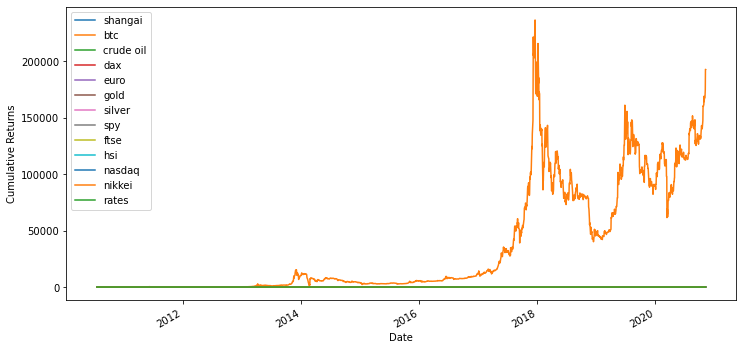

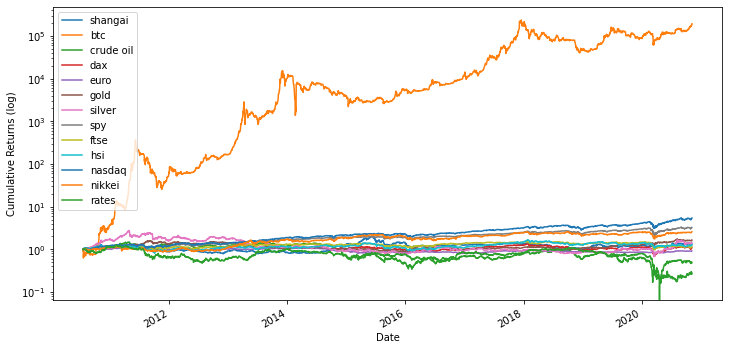

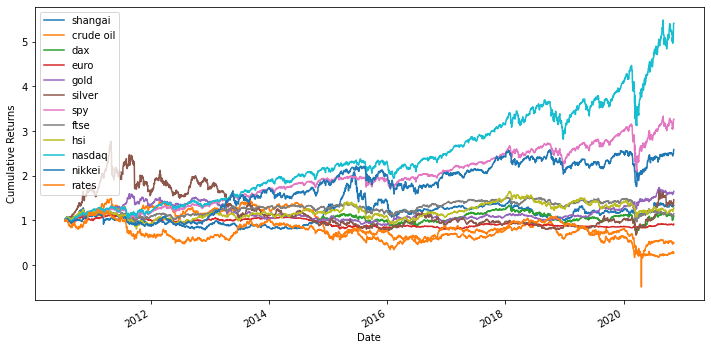

In [164]:
close = data_ohlc['Close'].fillna(method='ffill')
close.rename(columns = lambda x: change_name(clean_name(x,signs)), inplace=True)


close = close[close.btc.notnull()]
returns = close.pct_change(1)
returns
cumulative = (1+ returns).cumprod()
cumulative.plot(figsize=(12,6),ylabel='Cumulative Returns')

cumulative.plot(figsize=(12,6),ylabel='Cumulative Returns (log)', logy=True)

cumulative.loc[:,cumulative.columns != 'btc'].plot(
    figsize=(12,6), ylabel='Cumulative Returns')

## Performing technical analysis calculations

In [169]:
def transform_ma(data, ma1, ma2, ma3):
    data['MA'+str(ma1)] = round(data['Close'].rolling(ma1).mean(),0)
    data['MA'+str(ma2)] = round(data['Close'].rolling(ma2).mean(),0)
    data['MA'+str(ma3)] = round(data['Close'].rolling(ma3).mean(),0)    
    return data

In [174]:
def transform_rsi(data, alpha=14, smoothK=3, smoothD=3):
    
    data['change'] = data['Close'].pct_change(1)
    data['k'] = 0
    data['d'] = 0

    cond_k = data.change > 0
    cond_d = data.change < 0

    data['k'] = data.k.mask(cond_k, data['change'])
    data['d'] = data.d.mask(cond_d, - data['change'])
    # data['num'] = data['k'].rolling(alpha).mean()
    
    data['num'] = pd.Series.ewm(data['k'], span=alpha).mean()
    data['div'] = pd.Series.ewm(data['d'], span=alpha).mean()
    
    # data['div'] = data['d'].rolling(alpha).mean()
    data['rs'] = data['num']/data['div']
    data['RSI'] = (100 - (100/(1+data['rs'])))
    data['RSImin'] = data['RSI'].rolling(alpha).min()
    data['RSImax'] = data['RSI'].rolling(alpha).max()
    data['stochRSI'] = 100*(data['RSI'] - data['RSImin']) / (data['RSImax'] - data['RSImin'])
    data['smoothK'] = round(data['stochRSI'].rolling(smoothK).mean(),2)
    data['smoothD'] = round(data['smoothK'].rolling(smoothD).mean(),2)
    data['K1'] = data['smoothK'].shift(1)
    data['D1'] = data['smoothD'].shift(1)


    # cond_num_zero = data.num == 0
    # data['RSI'] = data.RSI.mask(cond_num_zero, 0)

    # cond_div_zero = data.div == 0
    # data['RSI'] = data.RSI.mask(cond_div_zero, 100)

    return data

In [175]:
btc = data_ticker['BTCUSD=X']
btc = btc[btc.Close.notnull()]
btc = transform_rsi(transform_ma(btc, 20, 50, 100))
btc

,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,MA100,change,...,div,rs,RSI,RSImin,RSImax,stochRSI,smoothK,smoothD,K1,D1
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-19,0.085840,0.077230,0.093070,0.080800,0.080800,4900.0,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-20,0.080800,0.074260,0.081810,0.074740,0.074740,2000.0,NaN,NaN,NaN,-0.075000,...,0.040179,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-21,0.074740,0.066340,0.079210,0.079210,0.079210,4200.0,NaN,NaN,NaN,0.059807,...,0.024830,0.920113,47.919729,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-22,0.079210,0.050500,0.081810,0.050500,0.050500,12900.0,NaN,NaN,NaN,-0.362454,...,0.128119,0.123769,11.013756,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-23,0.050500,0.050500,0.067670,0.062620,0.062620,14100.0,NaN,NaN,NaN,0.240000,...,0.094693,0.785019,43.978182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02,13737.038086,13243.155273,13808.321289,13550.483398,13550.483398,0.0,12172.0,11358.0,10808.0,0.000293,...,0.003735,3.639524,78.446066,61.072412,89.727640,60.629962,59.08,61.01,55.38,68.94
2020-11-03,13550.448242,13325.444336,13984.976562,13950.308594,13950.308594,0.0,12339.0,11409.0,10853.0,0.029506,...,0.003237,4.854811,82.920028,61.072412,89.727640,76.243037,65.78,60.08,59.08,61.01
2020-11-04,13950.483398,13580.480469,14218.763672,14133.715820,14133.715820,0.0,12512.0,11462.0,10899.0,0.013147,...,0.002806,5.479615,84.566983,61.072412,89.727640,81.990523,72.95,65.94,65.78,60.08


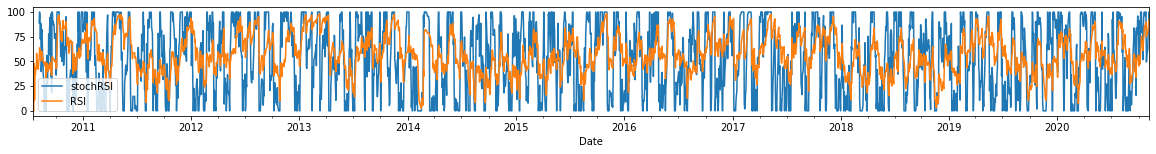

In [181]:
btc[['MA20','MA50', 'MA100', 'stochRSI', 'RSI']]

,MA20,MA50,MA100,stochRSI,RSI
Date,,,,,
2010-07-19,NaN,NaN,NaN,NaN,NaN
2010-07-20,NaN,NaN,NaN,NaN,0.000000
2010-07-21,NaN,NaN,NaN,NaN,47.919729
2010-07-22,NaN,NaN,NaN,NaN,11.013756
2010-07-23,NaN,NaN,NaN,NaN,43.978182
...,...,...,...,...,...
2020-11-02,12172.0,11358.0,10808.0,60.629962,78.446066
2020-11-03,12339.0,11409.0,10853.0,76.243037,82.920028
2020-11-04,12512.0,11462.0,10899.0,81.990523,84.566983


In [183]:
data = pd.concat([cumulative, btc[['MA20','MA50', 'MA100', 'stochRSI', 'RSI']]], axis=1)
data

,shangai,btc,crude oil,dax,euro,gold,silver,spy,ftse,hsi,nasdaq,nikkei,rates,MA20,MA50,MA100,stochRSI,RSI
Date,,,,,,,,,,,,,,,,,,
2010-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-20,1.021535,0.925000,1.011759,NaN,0.996416,1.008293,1.008612,1.011091,0.998291,1.008643,1.011036,1.000000,0.989204,NaN,NaN,NaN,NaN,0.000000
2010-07-21,1.024227,0.980322,1.000261,NaN,0.986747,1.008378,1.015056,0.997949,1.012878,1.019724,0.995042,0.986232,0.975708,NaN,NaN,NaN,NaN,47.919729
2010-07-22,1.035140,0.625000,1.036060,NaN,0.997187,1.011678,1.033136,1.020226,1.032147,1.024825,1.021681,0.980073,0.989204,NaN,NaN,NaN,NaN,11.013756
2010-07-23,1.039027,0.775000,1.031879,NaN,0.997960,1.005077,1.032052,1.029080,1.031914,1.036055,1.032408,1.002402,1.010121,NaN,NaN,NaN,NaN,43.978182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02,1.302857,167704.008988,0.480925,1.020198,0.899738,1.599729,1.369111,3.077640,1.098421,1.217464,4.984742,2.476040,0.286437,12172.0,11358.0,10808.0,60.629962,78.446066
2020-11-03,1.321421,172652.340806,0.492030,1.057267,0.899790,1.615046,1.386164,3.131979,1.124022,1.241342,5.077071,2.476040,0.297571,12339.0,11409.0,10853.0,76.243037,82.920028
2020-11-04,1.323993,174922.232312,0.511497,1.070812,0.909019,1.603283,1.361013,3.201976,1.142766,1.238674,5.272779,2.518529,0.259109,12512.0,11462.0,10899.0,81.990523,84.566983


In [184]:
data.describe()

,shangai,btc,crude oil,dax,euro,gold,silver,spy,ftse,hsi,nasdaq,nikkei,rates,MA20,MA50,MA100,stochRSI,RSI
count,2776.000000,2776.000000,2776.000000,1663.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2671.000000,2641.000000,2591.000000,2676.000000,2689.000000
mean,1.138731,36521.817101,0.898233,1.058095,0.938821,1.180366,1.201090,1.986364,1.274782,1.200197,2.454109,1.781001,0.740193,2757.187196,2723.870504,2670.208028,53.123593,57.404217
std,0.208827,49511.000108,0.308902,0.102163,0.086151,0.176210,0.398085,0.597050,0.132684,0.155118,1.044543,0.530622,0.214473,3858.560826,3770.611803,3635.474492,35.587404,19.261564
min,0.787750,0.625000,-0.491638,0.688515,0.803007,0.889227,0.669271,0.980800,0.960395,0.808835,0.961696,0.867315,0.168354,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.954937,628.712886,0.644500,0.988574,0.864420,1.052446,0.925174,1.445778,1.157639,1.094805,1.466520,1.310608,0.613698,29.500000,49.000000,73.500000,20.127310,44.194210
50%,1.163567,6591.893821,0.806833,1.052475,0.910658,1.115765,1.016824,1.938438,1.286396,1.171559,2.247185,1.854815,0.753036,474.000000,505.000000,529.000000,55.326393,56.310771
75%,1.268493,78743.009707,1.213516,1.126911,1.017956,1.314632,1.392765,2.520645,1.395383,1.311069,3.315922,2.251517,0.889339,5612.000000,5446.000000,5498.000000,87.065011,71.609577
max,2.087059,236562.001595,1.488503,1.338614,1.147194,1.736058,2.770845,3.333955,1.530117,1.650202,5.484613,2.585491,1.256748,16086.000000,13610.000000,11292.000000,100.000000,98.480853


In [185]:
data.corr()

,shangai,btc,crude oil,dax,euro,gold,silver,spy,ftse,hsi,nasdaq,nikkei,rates,MA20,MA50,MA100,stochRSI,RSI
shangai,1.000000,0.313517,-0.677569,0.339242,-0.625160,-0.279052,-0.408795,0.458189,0.356685,0.500405,0.444845,0.584743,-0.103317,0.305343,0.291259,0.272505,-0.014518,-0.008726
btc,0.313517,1.000000,-0.464962,0.400115,-0.425439,0.241089,-0.364546,0.844827,0.471538,0.690917,0.872372,0.736224,-0.295645,0.985099,0.962240,0.929980,-0.039244,-0.049959
crude oil,-0.677569,-0.464962,1.000000,0.568849,0.882127,0.179853,0.655321,-0.676148,-0.298385,-0.330906,-0.673741,-0.708880,0.475693,-0.447583,-0.447265,-0.438827,0.009153,0.048685
dax,0.339242,0.400115,0.568849,1.000000,0.541984,0.008612,0.207864,0.332665,0.654436,0.730360,0.256638,0.611754,0.365897,0.416248,0.386254,0.348315,-0.038588,0.003629
euro,-0.625160,-0.425439,0.882127,0.541984,1.000000,0.287185,0.737420,-0.705409,-0.493591,-0.380921,-0.662210,-0.753589,0.397575,-0.405234,-0.400969,-0.399141,-0.000642,0.033154
gold,-0.279052,0.241089,0.179853,0.008612,0.287185,1.000000,0.659614,-0.022464,-0.478378,-0.226993,0.106610,-0.284226,-0.572819,0.209345,0.206682,0.198633,0.044864,0.068681
silver,-0.408795,-0.364546,0.655321,0.207864,0.737420,0.659614,1.000000,-0.644392,-0.639467,-0.497806,-0.558955,-0.777950,0.040598,-0.367146,-0.374712,-0.378646,0.045368,0.120576
spy,0.458189,0.844827,-0.676148,0.332665,-0.705409,-0.022464,-0.644392,1.000000,0.678948,0.728530,0.984056,0.947924,-0.318425,0.841607,0.844198,0.850474,-0.037742,-0.095168
ftse,0.356685,0.471538,-0.298385,0.654436,-0.493591,-0.478378,-0.639467,0.678948,1.000000,0.804188,0.560272,0.766431,0.234765,0.473893,0.456016,0.443121,-0.051271,-0.041178
hsi,0.500405,0.690917,-0.330906,0.730360,-0.380921,-0.226993,-0.497806,0.728530,0.804188,1.000000,0.677528,0.767342,0.188941,0.700152,0.697224,0.694577,-0.047802,-0.068587


<AxesSubplot:>

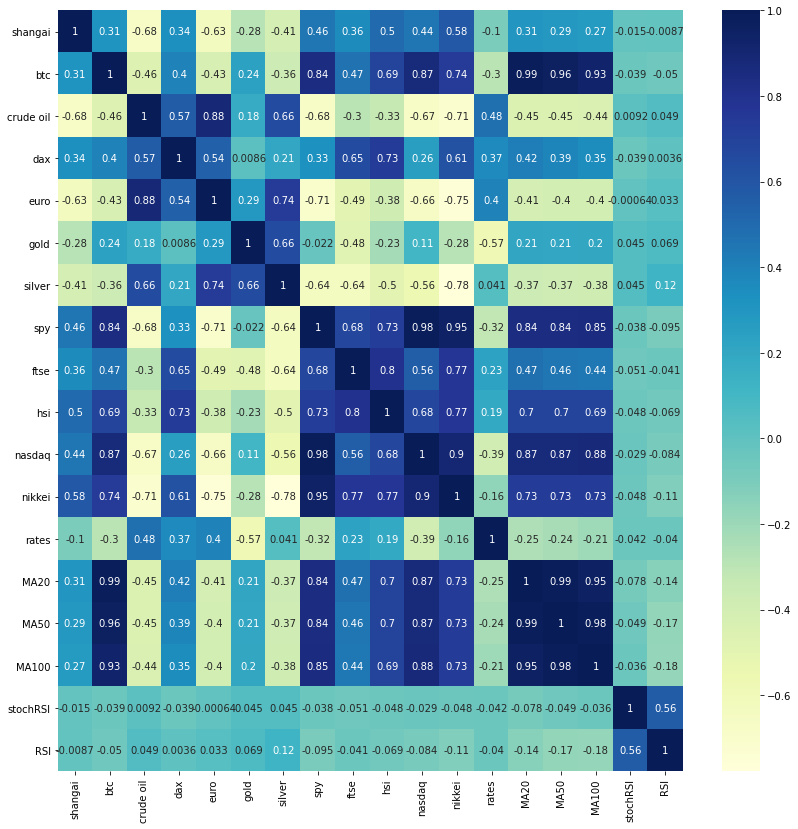

In [191]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(data.corr(), 
        xticklabels=data.corr().columns,
        yticklabels=data.corr().columns, ax=ax, annot=True, cmap="YlGnBu")